In [1]:
import os
import meld
import numpy as np
import pandas as pd
import scanpy as sc
sc.set_figure_params()
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from collections import OrderedDict
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### set params for meld
beta = 10  # amount of smoothing to apply
knn = 4  # number of neighbors to use

### Baselines

In [3]:
### Kmeans-based gating
adata_kmeans = ad.read_h5ad("../results/bcr_xl_kmeans.h5ad")
sc.pp.neighbors(adata_kmeans, use_rep='X')
sc.tl.umap(adata_kmeans)

### get predicted probability
prob_density = meld.MELD(
    beta=beta, knn=knn, sample_normalize=True
).fit_transform(adata_kmeans.X, adata_kmeans.obs['phenotype'].values)
prob_kmeans = meld.utils.normalize_densities(prob_density)

Building graph on 16 samples and 8 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


In [4]:
### PhenoGraph-based gating
adata_phenograph = ad.read_h5ad("../results/bcr_xl_phenograph.h5ad")
sc.pp.neighbors(adata_phenograph, use_rep='X')
sc.tl.umap(adata_phenograph)

### get predicted probability
prob_density = meld.MELD(
    beta=beta, knn=knn, sample_normalize=True
).fit_transform(adata_phenograph.X, adata_phenograph.obs['phenotype'].values)
prob_phenotype = meld.utils.normalize_densities(prob_density)

Building graph on 16 samples and 8 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


In [5]:
### Leiden-Umap method
adata_leidenumap = ad.read_h5ad("../results/bcr_xl_leiden_umap.h5ad")
sc.pp.neighbors(adata_leidenumap, use_rep='X')
sc.tl.umap(adata_leidenumap)

### get predicted probability
prob_density = meld.MELD(
    beta=beta, knn=knn, sample_normalize=True
).fit_transform(adata_leidenumap.X, adata_leidenumap.obs['phenotype'].values)
prob_leidenumap = meld.utils.normalize_densities(prob_density)

Building graph on 16 samples and 8 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


In [6]:
### Ground Truth
adata_truegating = ad.read_h5ad("../results/bcr_xl_true_gating.h5ad")
sc.pp.neighbors(adata_truegating, use_rep='X')
sc.tl.umap(adata_truegating)

### get predicted probability
prob_density = meld.MELD(
    beta=beta, knn=knn, sample_normalize=True
).fit_transform(adata_truegating.X, adata_truegating.obs['phenotype'].values)
prob_truegating = meld.utils.normalize_densities(prob_density)

Building graph on 16 samples and 8 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


### CytoEMD Method

In [7]:
adata_cytoemd = ad.read_h5ad("../results/bcr_xl_cytoemd.h5ad")
scaler = preprocessing.StandardScaler().fit(adata_cytoemd.X)
adata_cytoemd.X = scaler.transform(adata_cytoemd.X)

### get predicted probability
prob_density = meld.MELD(
    beta=beta, knn=knn, sample_normalize=True
).fit_transform(adata_cytoemd.X, adata_cytoemd.obs['phenotype'].values)
prob_cytoemd = meld.utils.normalize_densities(prob_density)

Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


### ROC-AUC

In [8]:
### ROC Kmeans
fpr_kmeans, tpr_kmeans, _ = metrics.roc_curve(
    adata_kmeans.obs['phenotype'].values,
    prob_kmeans['BCR-XL'], pos_label='BCR-XL'
)
auc_kmeans = metrics.auc(fpr_kmeans, tpr_kmeans)

### ROC PhenoGraph
fpr_phenograph, tpr_phenograph, _ = metrics.roc_curve(
    adata_phenograph.obs['phenotype'].values,
    prob_phenotype['BCR-XL'], pos_label='BCR-XL'
)
auc_phenograph = metrics.auc(fpr_phenograph, tpr_phenograph)

### ROC Leiden-Umap
fpr_leidenumap, tpr_leidenumap, _ = metrics.roc_curve(
    adata_leidenumap.obs['phenotype'].values,
    prob_leidenumap['BCR-XL'], pos_label='BCR-XL'
)
auc_leidenumap = metrics.auc(fpr_leidenumap, tpr_leidenumap)

### ROC True gating
fpr_truegating, tpr_truegating, _ = metrics.roc_curve(
    adata_truegating.obs['phenotype'].values,
    prob_truegating['BCR-XL'], pos_label='BCR-XL'
)
auc_truegating = metrics.auc(fpr_truegating, tpr_truegating)

### ROC CytoEMD
fpr_cytoemd, tpr_cytoemd, _ = metrics.roc_curve(
    adata_cytoemd.obs['phenotype'].values,
    prob_cytoemd['BCR-XL'], pos_label='BCR-XL'
)
auc_cytoemd = metrics.auc(fpr_cytoemd, tpr_cytoemd)

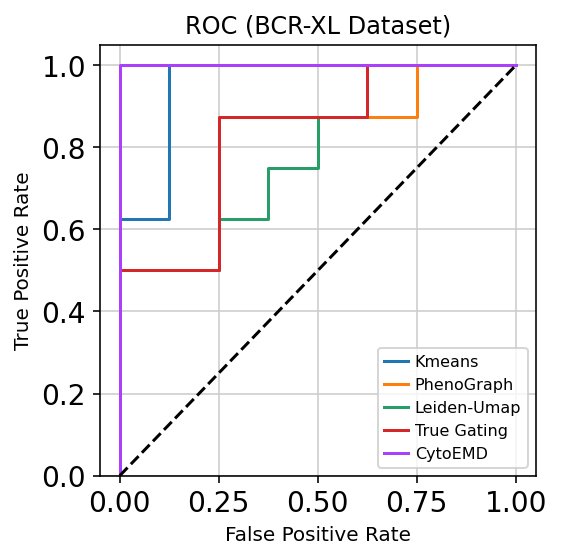

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# plot the roc curve
ax.plot(fpr_kmeans,     tpr_kmeans,     label='Kmeans')
ax.plot(fpr_phenograph, tpr_phenograph, label='PhenoGraph')
ax.plot(fpr_leidenumap, tpr_leidenumap, label='Leiden-Umap')
ax.plot(fpr_truegating, tpr_truegating, label='True Gating')
ax.plot(fpr_cytoemd,    tpr_cytoemd,    label='CytoEMD')

# add settings
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=10)
ax.set_ylabel("True Positive Rate", fontsize=10)
ax.set_title('ROC (BCR-XL Dataset)', fontsize=12)
ax.grid(":")
ax.legend(loc='best', handlelength=1.5, fontsize=8)

# plot y = x line
ax.plot([0, 1], [0, 1], 'k--')
plt.tight_layout()
plt.show()

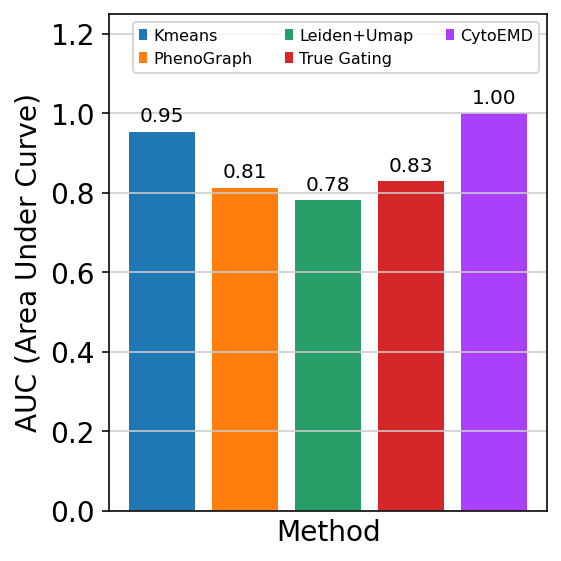

In [10]:
### AUC Barplot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

labels = ['Kmeans', 'PhenoGraph', 'Leiden+Umap', 'True Gating', 'CytoEMD']
width = 0.8
x = np.arange(5)

rec1 = ax.bar(x[0], auc_kmeans,     label=labels[0], )
rec2 = ax.bar(x[1], auc_phenograph, label=labels[1], )
rec3 = ax.bar(x[2], auc_leidenumap, label=labels[2], )
rec4 = ax.bar(x[3], auc_truegating, label=labels[3], )
rec5 = ax.bar(x[4], auc_cytoemd,    label=labels[4], )

ax.set_ylim([0, 1.25])
ax.set_xlabel("Method")
ax.set_ylabel("AUC (Area Under Curve)")
# ax.set_title("AUC of Different Methods")
ax.set_xticks([])
# ax.set_xticklabels(labels, rotation=45, fontsize=8)
ax.grid(':')
# ax.legend(loc='best', bbox_to_anchor=(1, 0.5), fontsize=8)
ax.legend(loc='best', ncol=3, fontsize=8)

ax.bar_label(rec1, fmt="%.2f", padding=3)
ax.bar_label(rec2, fmt="%.2f", padding=3)
ax.bar_label(rec3, fmt="%.2f", padding=3)
ax.bar_label(rec4, fmt="%.2f", padding=3)
ax.bar_label(rec5, fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()

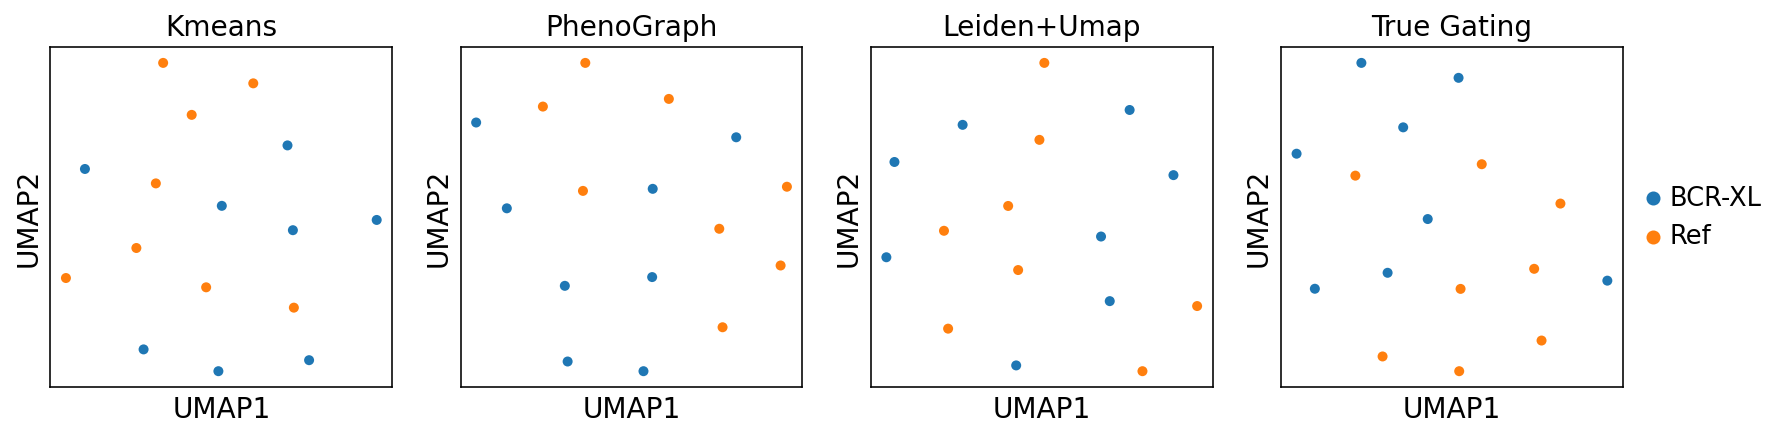

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14,3))

ax1_dict = sc.pl.umap(adata_kmeans,     color='phenotype', size=100, show=False, ax=ax1, title='Kmeans', legend_loc=None)
ax2_dict = sc.pl.umap(adata_phenograph, color='phenotype', size=100, show=False, ax=ax2, title='PhenoGraph', legend_loc=None)
ax3_dict = sc.pl.umap(adata_leidenumap, color='phenotype', size=100, show=False, ax=ax3, title='Leiden+Umap', legend_loc=None)
ax4_dict = sc.pl.umap(adata_truegating, color='phenotype', size=100, show=False, ax=ax4, title='True Gating')

# plt.savefig('./Res_UMAP.png', dpi=200, facecolor='white', bbox_inches='tight')